# 1] Tools (or Layers) we need to build Generator and Discriminator #
* Equalized Learning Rate Conv2d
* PixelNorm
* Convolution Block

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2

# In generator conv blocks, the channels go like "512->512->512->512->256->128->64->32->16"
factors = [1,1,1,1,1/2,1/4,1/8,1/16,1/32]

# Equalized learning rate applied on conv2d layers -- from ProGan paper
# in convolution operation: pixel * {weight * (1/norm)} <==> {pixel * (1/norm)} * weight 
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    # x-shape: Batch Size x Channels x H X W
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

# This ConvBlock will be used for both Generator and Discriminator, but inside, pixelnorm(after leakyReLU) is used only in Generator
# Be careful: the order is "conv2d-activation-norm", not "conv2d-norm-activation"
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

# **2] Generator**

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()
        # starting structure of Generator should be opposite of ending structure of Discriminator
        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps): ## steps=0 : 4x4 output / steps=1 : 8x8 output / steps=2 : 16x16 output ...
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

# 3] Discriminator
**(Or 'Critic' because Wasserstain loss is used)**


In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            
            ## rgb_layers list : [(1024x1024 input'from_rgb' layer),(512x512 input'from_rgb' layer),(256x256 input'from_rgb' layer) ...]
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        ## this 'from-rgb' layer is for 4x4 resolution
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        ## ConvBlock for 4x4 resolution
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):     ## NxCxHxW -> N -> 1 -> Nx1xHxW
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):     ## steps=0 : 4x4 input / steps=1 : 8x8 input ...
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [9]:
def test():
    Z_DIM = 100
    IN_CHANNELS = 128
    IMG_CHANNELS = 3
    gen = Generator(Z_DIM,IN_CHANNELS,IMG_CHANNELS)
    critic = Discriminator(IN_CHANNELS,IMG_CHANNELS)
    
    for img_size in [4,8,16,32,64,128]:
        num_steps = int(log2(img_size/4))
        z = torch.randn((1,Z_DIM,1,1))
        generated = gen(z,0.5,steps=num_steps)
        
        assert generated.shape == (1,IMG_CHANNELS,img_size,img_size)
        
        critic_generated = critic(generated,0.5,steps=num_steps)
        
        assert critic_generated.shape == (1,1)
        print(f"Succes at image size {img_size}x{img_size}")

test()

Succes at image size 4x4
Succes at image size 8x8
Succes at image size 16x16
Succes at image size 32x32
Succes at image size 64x64
Succes at image size 128x128


# Configurations & Hyperparameters

# Utils

In [11]:
import random
import torchvision
from torchvision.utils import save_image

def save_on_tensorboard(writer,loss_critic,loss_gen,real,fake,tensorboard_step):
    writer.add_scalar("Loss Critic",loss_critic,global_step=tensorboard_step)
    writer.add_scalar("Loss Generator", loss_gen, global_step=tensorboard_step)
    
    with torch.no_grad():
        img_grid_real = torchvision.utils.make_grid(real[:8],normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8],normalize=True)
        
        writer.add_image("Real",img_grid_real,global_step = tensorboard_step)
        writer.add_image("Fake",img_grid_fake,global_step = tensorboard_step)
        
def gradient_penalty(critic,real,fake,alpha,train_step,device="cpu"):
    BATCH_SIZE,C,H,W = real.shape
    beta = torch.rand((BATCH_SIZE,1,1,1)).repeat(1,C,H,W).to(device)
    
    interpolated_images = real * beta + fake.detach() * (1-beta)
    interpolated_images.requires_grad_(True)
    
    ## Calculate critic scores
    mixed_scores = critic(interpolated_images,alpha,train_step)
    
    ## Take the gradient of the scores with respect to the image
    gradient = torch.autograd.grad(
        inputs = interpolated_images,
        outputs = mixed_scores,
        grad_outputs = torch.ones_like(mixed_scores),
        create_graph = True,
        retain_graph = True
    )[0]
    
    gradient = gradient.view(gradient.shape[0],-1)
    gradient_norm = gradient.norm(2,dim=1)
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

    

def save_checkpoint(model, optimizer, step, filename="my_checkpoint.pth"):
    print("Saving Checkpoint")
    checkpoint = {
        "step": step,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

    
"""def load_checkpoint(checkpoint_file,model,optimizer,lr):
    print("Loading Checkpoint")
    checkpoint = torch.load(checkpoint_file,map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
        """

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("Loading Checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    
    if "step" in checkpoint:
        step = checkpoint["step"]
        print(f"Loaded step: {step}")
    else:
        step = 0
        print("Step not found in checkpoint. Starting from step 0.")
    
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
    
    return step  # Return loaded or default step


        
def generate_examples(gen,current_epoch,steps,n=16):
    gen.eval()
    aplha = 1.0
    
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1,Z_DIM,1,1).to(DEVICE)
            generated_img = gen(noise,alpha=alpha,steps=steps)
            save_image(generated_img*0.5+0.5,f"generated_images/step{steps}_epoch{current_epoch}_{i}.png")
#             save_image(generated_img*0.5+0.5,f"step:{steps}_epoch{current_epoch}_{i}.png")
    
    gen.train()

# Train

In [12]:
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [13]:
torch.backends.cudnn.benchmarks = True
import matplotlib.pyplot as plt
import torch
from scipy.linalg import sqrtm
def calculate_swd(real_images, generated_images):
    real_images = real_images.float()
    generated_images = generated_images.float()

    batch_size = min(real_images.size(0), generated_images.size(0))

    swd_values = []

    for i in range(batch_size):
        real_img = real_images[i]
        generated_img = generated_images[i]

        real_mean = torch.mean(real_img, dim=(1, 2))
        generated_mean = torch.mean(generated_img, dim=(1, 2))

        real_diff = real_img - real_mean.unsqueeze(-1).unsqueeze(-1)
        generated_diff = generated_img - generated_mean.unsqueeze(-1).unsqueeze(-1)

        real_cov = torch.matmul(real_diff.view(real_diff.size(0), -1), real_diff.view(real_diff.size(0), -1).transpose(0, 1)) / (real_img.numel() - 1)
        generated_cov = torch.matmul(generated_diff.view(generated_diff.size(0), -1), generated_diff.view(generated_diff.size(0), -1).transpose(0, 1)) / (generated_img.numel() - 1)

        # Compute square root of real_cov using PyTorch
        real_cov_sqrt = sqrtm(real_cov.cpu().detach().numpy()).real
        real_cov_sqrt = torch.from_numpy(real_cov_sqrt).to(real_images.device)

        # Compute SWD value for this pair of images
        swd_value = torch.norm(torch.matmul(torch.matmul(generated_cov, real_cov_sqrt), generated_cov))

        swd_values.append(swd_value.item())

    avg_swd_value = sum(swd_values) / len(swd_values)

    return avg_swd_value


# Initialize empty lists for storing losses
step_losses_gen = []
step_losses_critic = []
step_swd_values = []  # Initialize step-wise SWD values
step_losses_critic_fake  = []
step_losses_critic_real  = []
step_losses_gen_fake  = []

epoch_real_data = []  # List to store real data points
epoch_fake_data = []  # List to store fake data points


# Function to plot losses
def plot_step_losses(step_losses_gen, step_losses_critic, step_swd_values):
    plt.figure(figsize=(15, 5))

    # Plot generator and critic losses
    plt.subplot(1, 2, 1)
    plt.plot(step_losses_gen, label='Generator Loss')
    plt.plot(step_losses_critic, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.grid(True)

    # Plot SWD values
    plt.subplot(1, 2, 2)
    plt.plot(step_swd_values, label='SWD Value', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('SWD Value')
    plt.title('SWD Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    
def plot_real_fake_distribution(real_data, fake_data):
    real_data = np.concatenate(real_data, axis=0)  # Combine all batches into a single numpy array
    fake_data = np.concatenate(fake_data, axis=0)  # Combine all batches into a single numpy array
    
    plt.figure(figsize=(8, 6))
    plt.scatter(real_data[:, 0], real_data[:, 1], color='blue', label='Real data')
    plt.scatter(fake_data[:, 0], fake_data[:, 1], color='red', label='Generated data')
    plt.title('Real vs Generated data distribution')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_real_distribution(real_data):
    real_data = np.concatenate(real_data, axis=0)  # Combine all batches into a single numpy array
    
    plt.figure(figsize=(8, 6))
    plt.scatter(real_data[:, 0], real_data[:, 1], color='blue', label='Real data')
    plt.title('Real data distribution')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
def plot_fake_distribution(fake_data):
    fake_data = np.concatenate(fake_data, axis=0)  # Combine all batches into a single numpy array
    
    plt.figure(figsize=(8, 6))
    plt.scatter(fake_data[:, 0], fake_data[:, 1], color='red', label='Generated data')
    plt.title('Generated data distribution')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

Loading Checkpoint
Loaded step: 8
Loaded step from generator checkpoint: 8
Loading Checkpoint
Loaded step: 8
Loaded step from critic checkpoint: 8
Image size:512 | Current step:7
Epoch [1/1] Global Epoch:0


  0%|          | 0/881 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 881/881 [15:37<00:00,  1.05s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 881/881 [15:37<00:00,  1.06s/it]


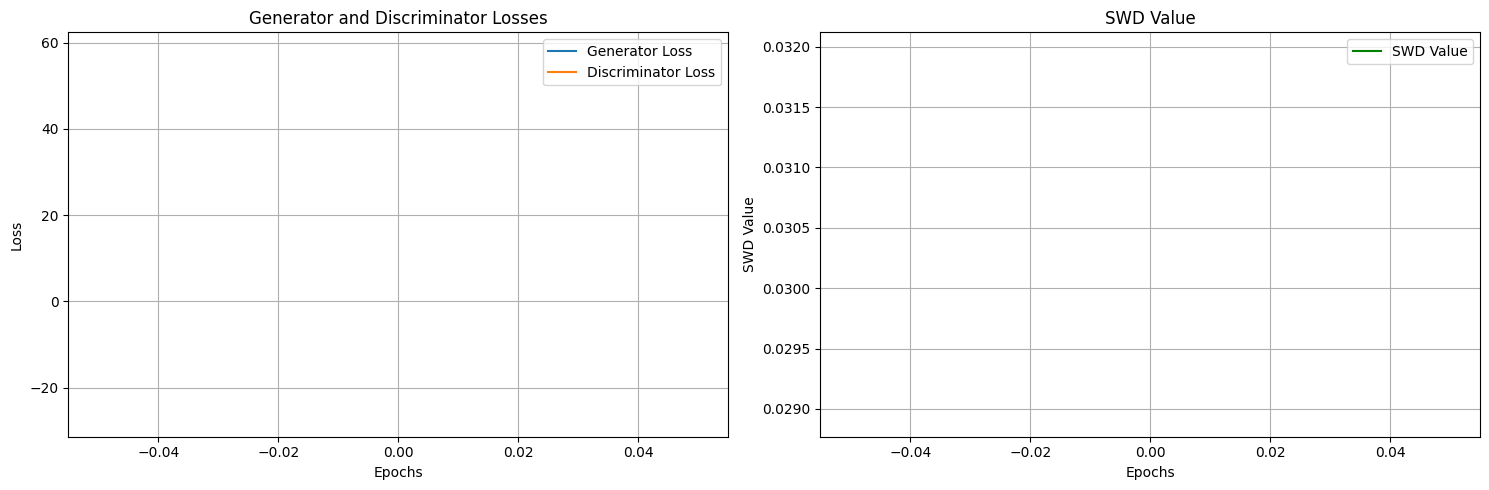

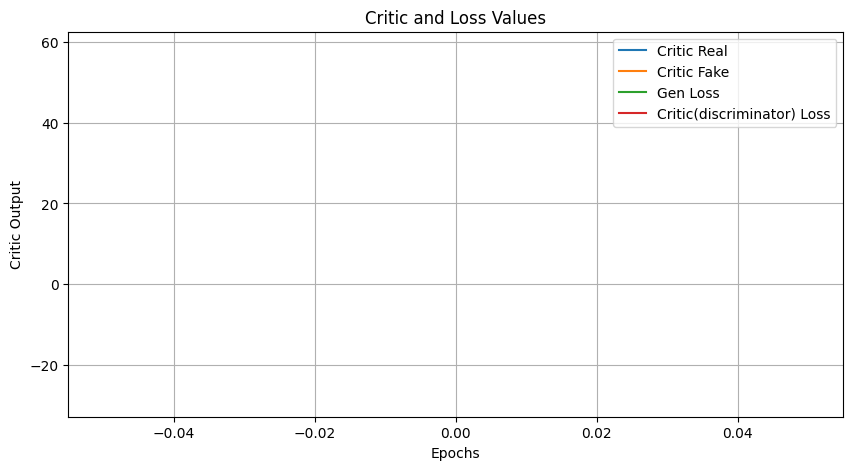

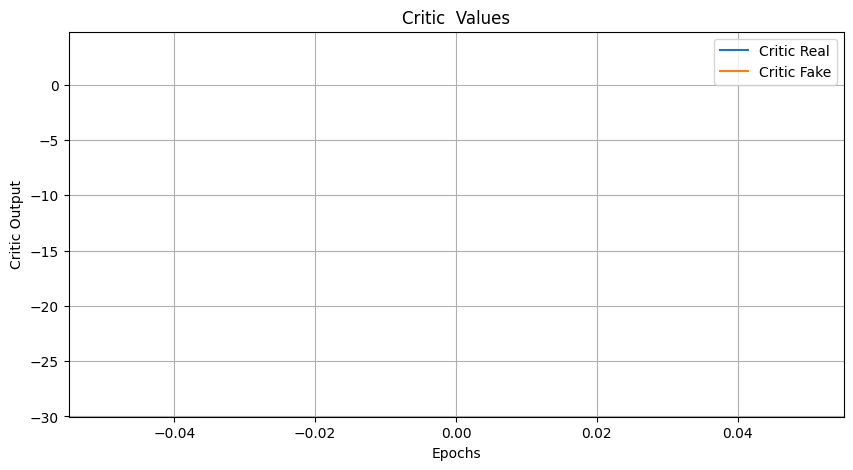

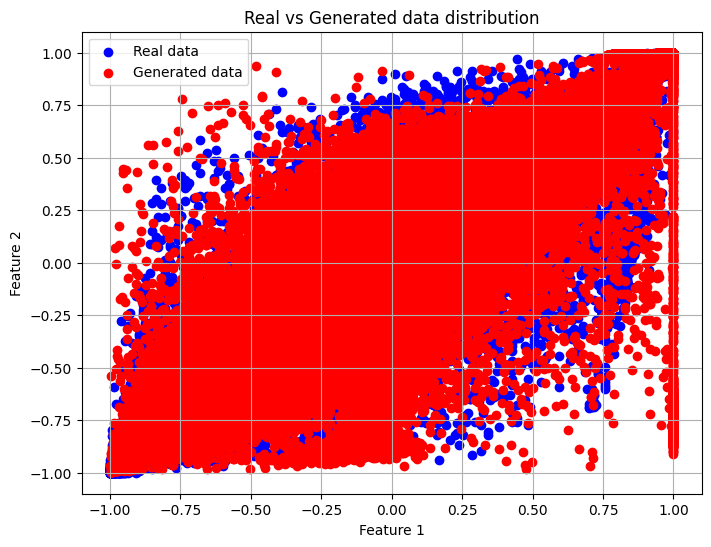

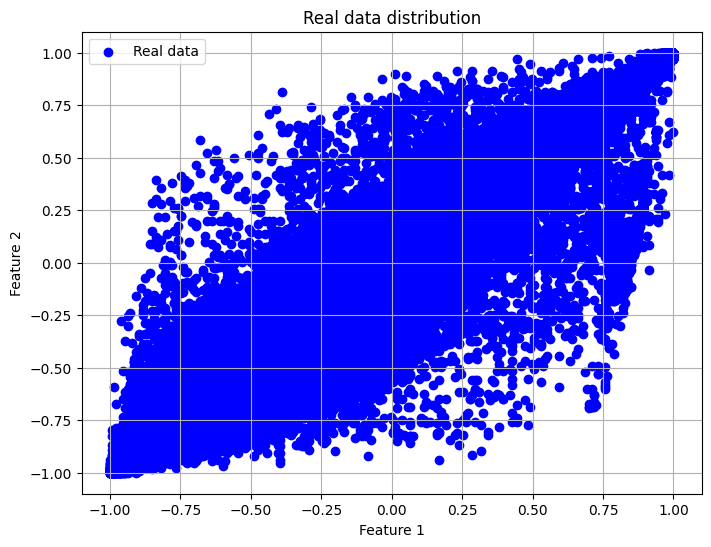

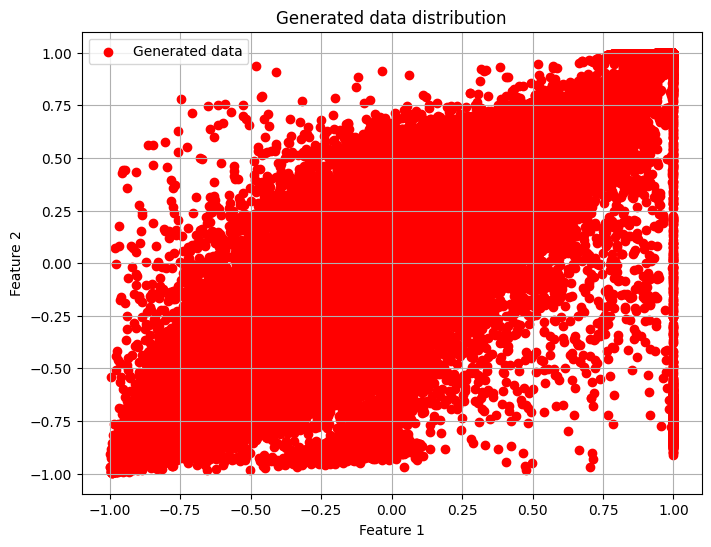

Saving Checkpoint
Saving Checkpoint
Training finished


In [14]:
def get_loader(img_size):
    transform = transforms.Compose(
    [
        transforms.Resize((img_size,img_size)),
        transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize([0.5 for _ in range(IMG_CHANNELS)],[0.5 for _ in range(IMG_CHANNELS)])
    ])
    
    batch_size = BATCH_SIZES[int(log2(img_size/4))]
    dataset = datasets.ImageFolder(root=DATASET,transform=transform)
    loader = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=NUM_WORKERS,pin_memory=True)
    
    return loader,dataset

def train_fn(gen,critic,loader,dataset,step,alpha,opt_gen,opt_critic,tensorboard_step,writer,scaler_gen,scaler_critic):
    loop = tqdm(loader,leave=True)
    
    
    epoch_losses_gen = []
    epoch_losses_critic = []
    epoch_swd_values = [] # Initialize step-wise SWD values
    epoch_critic_real = []  # Store critic values for real samples
    epoch_critic_fake = []  # Store critic values for fake samples
    epoch_gen_fake = []
    
    
    
    i = 0
    for batch_idx,(real,_) in enumerate(loop):
        i += 1
        if i%2 == 0:
            continue
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size,Z_DIM,1,1).to(DEVICE)
        
        ## Train Critic
        ## Wasserstein Loss : Maximize "E[Critic(real)] - E[Critic(fake)]"   ==   Minimize "-(E[Critic(real)] - E[Critic(fake)])"
        with torch.cuda.amp.autocast():
            fake = gen(noise,alpha,step).to(DEVICE)
            critic_real = critic(real,alpha,step)
            critic_fake = critic(fake.detach(),alpha,step)
            gp = gradient_penalty(critic,real,fake,alpha,step,device=DEVICE)
            loss_critic = -1 * (torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp + 0.001 * torch.mean(critic_real**2)
        
        critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()
        
        ## Train Generator
        ## Maximize "E[Critic(fake)]"   ==   Minimize "- E[Critic(fake)]"
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake,alpha,step)
            loss_gen = -1 * torch.mean(gen_fake)
            
        gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()
    
        alpha += (cur_batch_size/len(dataset)) * (1/PROGRESSIVE_EPOCHS[step]) * 2
        alpha = min(alpha,1)
        
        
        
        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen(FIXED_NOISE,alpha,step) * 0.5 + 0.5
                save_on_tensorboard(writer,loss_critic.item(),loss_gen.item(),real.detach(),fixed_fakes.detach(),tensorboard_step)
                tensorboard_step += 1
                # Plotting loss for critic and generator
                
        
        with torch.no_grad():
            fixed_fakes = gen(FIXED_NOISE, alpha, step).detach().cpu()
            real_cpu = real.detach().cpu()
            
            #fixed_fakes = gen(FIXED_NOISE, alpha, step).detach().cuda()
            #real_cpu = real.detach().cuda()

            swd_value = calculate_swd(real_cpu, fixed_fakes)
            epoch_swd_values.append(swd_value)
            
        
        torch.cuda.empty_cache()
        

        
    
    
    # Calculate average losses for the epoch
    epoch_losses_gen.append(loss_gen.item())
    epoch_losses_critic.append(loss_critic.item())

    # At the end of each step (after 100 epochs), compute average losses and store in step lists
    avg_loss_gen = sum(epoch_losses_gen) / len(epoch_losses_gen)
    avg_loss_critic = sum(epoch_losses_critic) / len(epoch_losses_critic)
    step_losses_gen.append(avg_loss_gen)
    step_losses_critic.append(avg_loss_critic)
    
                # Store critic_real and critic_fake values
    epoch_critic_real.append(torch.mean(critic_real.detach()).item())
    epoch_critic_fake.append(torch.mean(critic_fake.detach()).item())
    avg_loss_critic_fake = sum(epoch_critic_fake) / len(epoch_critic_fake)
    avg_loss_critic_real = sum(epoch_critic_real) / len(epoch_critic_real)
    step_losses_critic_fake.append(avg_loss_critic_fake)
    step_losses_critic_real.append(avg_loss_critic_real)    
    
    
    epoch_gen_fake.append(torch.mean(gen_fake.detach()).item())
    avg_loss_gen_fake = sum(epoch_gen_fake) / len(epoch_gen_fake)
    step_losses_gen_fake.append(avg_loss_gen_fake)
        
    
    avg_swd_value = sum(epoch_swd_values) / len(epoch_swd_values)
    step_swd_values.append(avg_swd_value)  # Append SWD value for plotting
    
    
    
    
        # Convert tensors to numpy arrays and flatten them if necessary
    real_data = real.detach().cpu().numpy().reshape(-1, 2)  # Assuming 2D data, reshape accordingly
    fake_data = fake.detach().cpu().numpy().reshape(-1, 2)  # Assuming 2D data, reshape accordingly

    epoch_real_data.append(real_data)
    epoch_fake_data.append(fake_data)
        
        
    return tensorboard_step,alpha
        
## build model
gen = Generator(Z_DIM,IN_CHANNELS,IMG_CHANNELS).to(DEVICE)
critic = Discriminator(IN_CHANNELS,IMG_CHANNELS).to(DEVICE)

## initialize optimizer,scalers (for FP16 training)
opt_gen = optim.Adam(gen.parameters(),lr=LR,betas=(0.0,0.99))
opt_critic = optim.Adam(critic.parameters(),lr=LR,betas=(0.0,0.99))
scaler_gen = torch.cuda.amp.GradScaler()
scaler_critic = torch.cuda.amp.GradScaler()

## tensorboard writer
writer = SummaryWriter(f"runs/PG_GAN")
tensorboard_step = 0
#step = None 
## if checkpoint files exist, load model
if LOAD_MODEL:
    if os.path.exists(CHECKPOINT_GEN):
        checkpoint_gen = load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LR)
        if isinstance(checkpoint_gen, int):
            step = checkpoint_gen
            print(f"Loaded step from generator checkpoint: {step}")
        else:
            print(f"Step not found in generator checkpoint. Starting from step 0.")
            step = 0  # Set default step if checkpoint not found
    else:
        print(f"Generator checkpoint file '{CHECKPOINT_GEN}' not found!")
        step = 0  # Set default step if checkpoint not found

    if os.path.exists(CHECKPOINT_CRITIC):
        checkpoint_critic = load_checkpoint(CHECKPOINT_CRITIC, critic, opt_critic, LR)
        if isinstance(checkpoint_critic, int):
            step = checkpoint_critic
            print(f"Loaded step from critic checkpoint: {step}")
        else:
            print(f"Step not found in critic checkpoint. Using current step value.")
    else:
        print(f"Critic checkpoint file '{CHECKPOINT_CRITIC}' not found!")


gen.train()
critic.train()

# Start from the loaded step or from the beginning if not loaded
#step = step if LOAD_MODEL else 0

#step = int(log2(START_TRAIN_IMG_SIZE/4)) ## starts from 0
step = 7

global_epoch = 0
generate_examples_at = list(range(1, 601, 1))


for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    if step == 8:
        break
    alpha = 1e-4
    loader,dataset = get_loader(4*2**step)
    print(f"Image size:{4*2**step} | Current step:{step}")
    
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}] Global Epoch:{global_epoch}")
        tensorboard_step,alpha = train_fn(gen,critic,loader,dataset,step,alpha,opt_gen,opt_critic,tensorboard_step,writer,scaler_gen,scaler_critic)
        global_epoch += 1
        if global_epoch in generate_examples_at:
            generate_examples(gen,global_epoch,step,n=20)


    plot_step_losses(step_losses_gen, step_losses_critic, step_swd_values)
    
            # Plot critic_real and critic_fake values
    plt.figure(figsize=(10, 5))
    plt.plot(step_losses_critic_real, label='Critic Real')
    plt.plot(step_losses_critic_fake, label='Critic Fake')
    #plt.plot(step_losses_gen_fake, label='Gen Fake')
    plt.plot(step_losses_gen, label='Gen Loss')
    plt.plot(step_losses_critic, label='Critic(discriminator) Loss')
    plt.legend()
    plt.title('Critic and Loss Values')
    plt.xlabel('Epochs')
    plt.ylabel('Critic Output')
    plt.grid(True)
    plt.show()
    
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(step_losses_critic_real, label='Critic Real')
    plt.plot(step_losses_critic_fake, label='Critic Fake')
    plt.legend()
    plt.title('Critic  Values')
    plt.xlabel('Epochs')
    plt.ylabel('Critic Output')
    plt.grid(True)
    plt.show()
    
    plot_real_fake_distribution(epoch_real_data, epoch_fake_data)
    plot_real_distribution(epoch_real_data)
    plot_fake_distribution(epoch_fake_data)
    
    
    
    step += 1 ## Progressive Growing
    if SAVE_MODEL:
        save_checkpoint(gen, opt_gen, step, filename="CHECKPOINT_GEN.pth")
        save_checkpoint(critic, opt_critic, step, filename="CHECKPOINT_CRITIC.pth")        
      
print("Training finished")

In [16]:
torch.cuda.empty_cache()

In [17]:
import os
import torch
import matplotlib.pyplot as plt

# Initialize generator and load its state from checkpoint
gen = Generator(Z_DIM, IN_CHANNELS, IMG_CHANNELS).to('cuda')  # Adjust device if necessary
checkpoint_path = "CHECKPOINT_GEN.pth"  # Replace with your actual path
checkpoint = torch.load(checkpoint_path)
gen.load_state_dict(checkpoint['state_dict'])

# Set the generator to evaluation mode
gen.eval()

# Function to generate and save images
def generate_and_save_images(generator, device, output_dir, num_images, alpha, steps):
    os.makedirs(output_dir, exist_ok=True)
    for i in range(num_images):
        # Generate random noise
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM, 1, 1).to(device)
            # Generate fake image
            generated_image = generator(noise, alpha, steps)
            # Denormalize image to display it correctly
            generated_image = generated_image * 0.5 + 0.5  # Assuming normalization was ([-1, 1])
            # Convert tensor to numpy array for saving
            generated_image = generated_image.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()

        # Save the image
        image_path = os.path.join(output_dir, f'generated_image_{i+1}.png')
        plt.imsave(image_path, generated_image)

        print(f'Saved {image_path}')

# Example usage: assuming alpha and steps
alpha = 1.0  # Adjust according to your training progression
steps = 6  # Adjust according to the current step of your trained model
num_images = 5000  # Number of images to generate

# Directory to save generated images
output_directory = "gen"

# Generate and save images
generate_and_save_images(gen, 'cuda', output_directory, num_images, alpha, steps)

'import os\nimport torch\nimport matplotlib.pyplot as plt\n\n# Initialize generator and load its state from checkpoint\ngen = Generator(Z_DIM, IN_CHANNELS, IMG_CHANNELS).to(\'cuda\')  # Adjust device if necessary\ncheckpoint_path = "../input/d/orthodontics/model-step4-64/CHECKPOINT_GEN.pth"  # Replace with your actual path\ncheckpoint = torch.load(checkpoint_path)\ngen.load_state_dict(checkpoint[\'state_dict\'])\n\n# Set the generator to evaluation mode\ngen.eval()\n\n# Function to generate and save images\ndef generate_and_save_images(generator, device, output_dir, num_images, alpha, steps):\n    os.makedirs(output_dir, exist_ok=True)\n    for i in range(num_images):\n        # Generate random noise\n        with torch.no_grad():\n            noise = torch.randn(1, Z_DIM, 1, 1).to(device)\n            # Generate fake image\n            generated_image = generator(noise, alpha, steps)\n            # Denormalize image to display it correctly\n            generated_image = generated_imag